# Jihye Jung PS5

This notebook is a template showing you how to use some tools that will be useful for problem set 5.

The tools are:
1. Qmod: an implementation of the q-Model as a class in python. This is used to obtain phase diagrams.
2. Dolo: a general purpose tool used to represent and solve economic models. This is used to compute optimal responses.

The use of both tools will make us have to handle two representations of our problems, one as a Qmod object, and one as a Dolo model.

Start by loading the tools we will be using.


In [139]:
# Preamble: import the packages we will be using

# Usual packages
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from dolo import *
import dolo.algos.perfect_foresight as pf
import pandas as pd

# Import the Qmod python code from external file

# Since the Qmod class is in other folder we need to
# change the path.
import sys
sys.path.append('../')
from Qmod import Qmod

In [140]:
import warnings
warnings.filterwarnings("ignore") 

I then define a function that takes two Qmod objects and plots their phase diagrams in the same figure.

In [141]:
def phase_diagrams(mod1,mod2,k_min,k_max,npoints = 300):
    """
    Draws the phase diagram of the Qmodel under two different sets of
    parameter values in the same figure, and returns it.

    Parameters:
        - mod1          : Qmod object representing the first set of parameter values.
        - mod1          : Qmod object representing the second set of parameter values.
        - [k_min,k_max] : limits for the value of capital in the phase diagrams.
        - npoints       : number of points in the capital grid to be used for phase
                          diagram plots.
    """

    # Create a figure
    fig, ax = plt.subplots()

    # Plot the loci of the pre and post-change models.
    k_range = np.linspace(k_min,k_max,npoints)
    mods = [mod1,mod2]
    colors = ['r','b']
    labels = ['Mod. 1','Mod. 2']
    for i in range(2):

        # Plot k0 locus
        ax.plot(k_range,mods[i].P*np.ones(npoints),
                 linestyle = '--', color = colors[i],label = labels[i] + ' loci')
        # Plot lambda0 locus
        ax.plot(k_range,[mods[i].lambda0locus(x) for x in k_range],
                 linestyle = '--', color = colors[i])
        # Plot steady state
        ax.plot(mods[i].kss,mods[i].P,marker = '*', color = colors[i])
        
        # Plot stable arm
        stab_arm = [mods[i].findLambda(k0 = x, k1 = mods[i].k1Func(x)) for x in k_range]
        ax.plot(k_range, stab_arm, linestyle = '-', color = colors[i], label = labels[i] + ' stable arm.')

    return(ax)

# Q1. unexpected permanent increase in corporate tax rate

Suppose tau increases from 0.05 to 0.2

In [190]:
# Base parameters

# Discount factor and return factor
beta = 0.98
R = 1/beta

# Tax rate
tau = 0.05

# Share of capital in production
alpha = 0.33

# Adjustment costs
omega = 1

# Investment tax credit
zeta = 0

# Depreciation rate
delta = 0.1

# Technological factor
psi = 1

## Qmod python class

# Create the object.
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
# Solve to find the steady state and policy rule.
Qmodel.solve()

## Dolo

# First import the external file with the model description.
QDolo = yaml_import("../Dolo/Q-model.yaml")

# Then replace the default parameters with our desired ones.
QDolo.set_calibration(alpha = alpha, delta = delta, omega = omega)

#############
# IMPORTANT #
#############

# We do not pass R, psi, tau, or itc because they are handled not as parameters
# but exogenous variables that can change over time. (see below)

,R,psi,itc_1,tau
0,1.020408,1,0,0.05
1,1.020408,1,0,0.20
2,1.020408,1,0,0.20
3,1.020408,1,0,0.20
4,1.020408,1,0,0.20


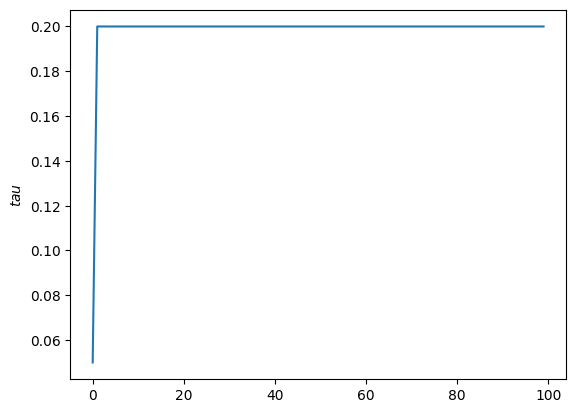

In [191]:
# Set up the basic features of the simulation

# Total simulation time
T = 100
# Initial level of capital
k0 = Qmodel.kss

# Design the shock:

# for this example, I am assuming that productivity increases and then
# goes back to the original level.

tau_high = 0.2
param_sequence_perm = np.array([tau]*1+
                        [tau_high]*99)
# Check the pattern of the shock
plt.figure()
plt.plot(param_sequence_perm)
plt.ylabel('$tau$')

# Dolo receives a DataFrame with the full future paths for ALL exogenous
# variables. So we create one:
Exog = pd.DataFrame({'R':[R]*T,
                     'psi':[psi]*T,
                     'itc_1':[zeta]*T,
                     'tau':param_sequence_perm})

# Examine the first few entries.
Exog.head()
# Note all other variables are left constant.

In [192]:
# Now use the "perfect foresight" dolo solver
response = pf.deterministic_solve(model = QDolo, # Model we are using (in dolo)
                                  shocks = Exog, # Paths for exog. variables 
                                  T=T,           # Total simulation time
                                  s1 = [k0],     # Initial state
                                  verbose=True)

# Response is a DataFrame with the paths of every variable over time.
# It adds information we don't need on the first row. So we delete it
response = response[1:]

# Inspect the first few elements.
response.head()

	> 1 | 0.06035111013995964 | 0
	> 2 | 0.017456704293846048 | 0
	> 3 | 0.002282168881514224 | 0
	> 4 | 4.6285962294612126e-05 | 0
	> 5 | 1.7903717064449154e-08 | 0
> System was solved after iteration 5. Residual=1.7903717064449154e-08


,k,i,y,y_k,beta,j,xi,iota,j_i,j_k,lambda_1,q_1,R,tau,itc_1,psi
1,4.298990,0.182338,1.618121,0.124211,0.98,0.007128,0.185677,-0.057586,-0.057586,0.004101,0.942414,0.942414,1.020408,0.2,0.0,1.0
2,4.051429,0.223371,1.586758,0.129246,0.98,0.004078,0.222900,-0.044866,-0.044866,0.003480,0.955134,0.955134,1.020408,0.2,0.0,1.0
3,3.869657,0.252377,1.562903,0.133283,0.98,0.002341,0.249623,-0.034781,-0.034781,0.002873,0.965219,0.965219,1.020408,0.2,0.0,1.0
4,3.735068,0.273197,1.544751,0.136482,0.98,0.001347,0.269053,-0.026856,-0.026856,0.002325,0.973144,0.973144,1.020408,0.2,0.0,1.0
5,3.634758,0.288330,1.530936,0.138994,0.98,0.000777,0.283324,-0.020674,-0.020674,0.001854,0.979326,0.979326,1.020408,0.2,0.0,1.0


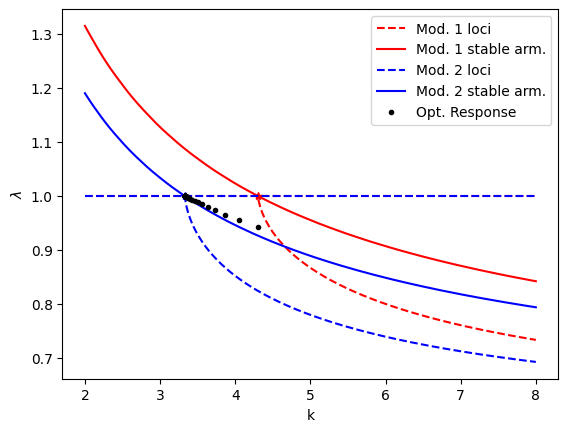

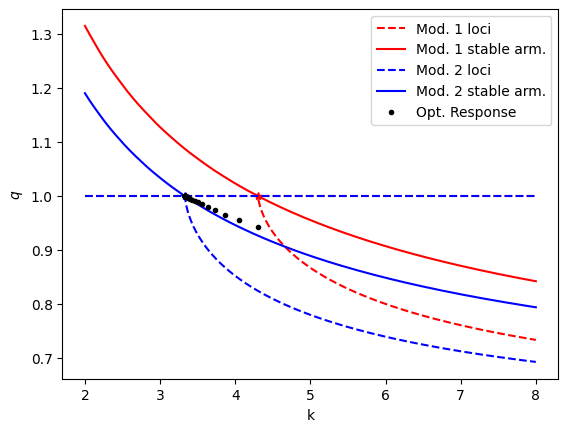

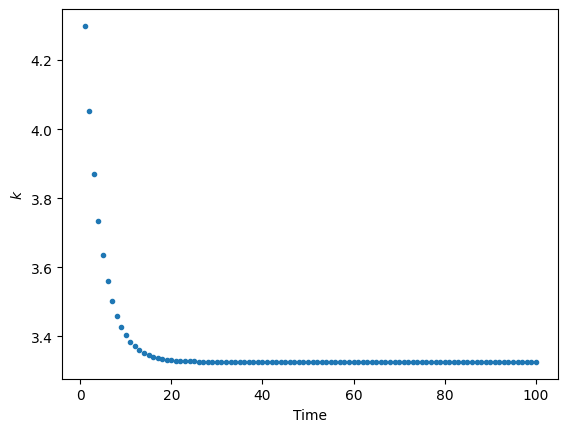

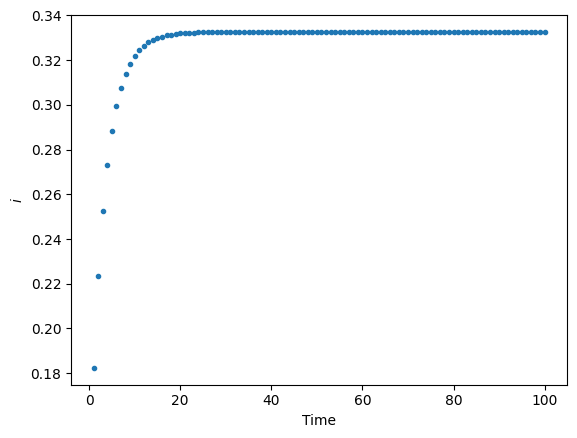

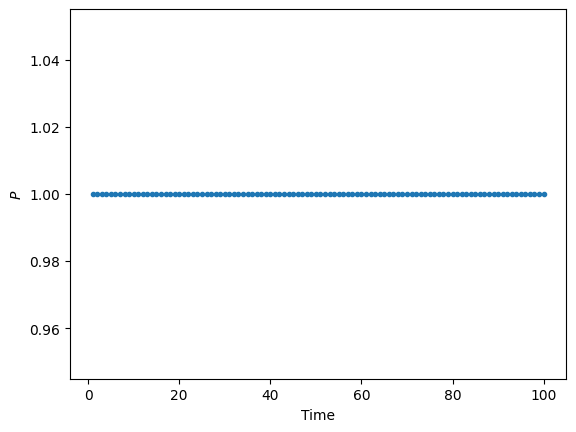

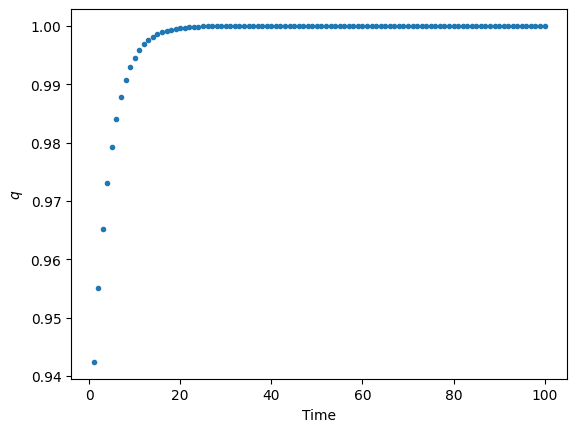

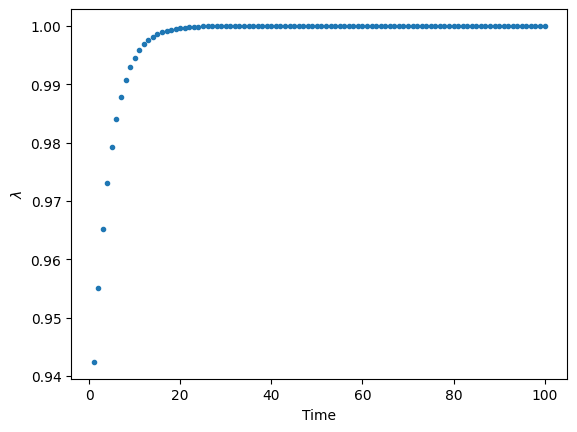

In [194]:
# Draw the two phase diagrams and save them in an object
# to add the plots of dynamics later.

# Copy the initial model, set the higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.tau = tau_high
Q_high_tau.solve()

# Now we draw the phase diagrams of our base model "Qmodel"
# lambda dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.lambda_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$\\lambda$')
plt.savefig('./fig/Q1_lambda'); plt.show()

# q dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.q_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$q$')
plt.savefig('./fig/Q1_q'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.k,'.')
plt.ylabel('$k$')
plt.xlabel('Time')
plt.savefig('./fig/Q1_k'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.i,'.')
plt.ylabel('$i$')
plt.xlabel('Time')
plt.savefig('./fig/Q1_i'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.lambda_1/response.q_1,'.')
plt.ylabel('$P$')
plt.xlabel('Time')
plt.savefig('./fig/Q1_P'); plt.show()

plt.figure()
plt.plot(response.q_1,'.')
plt.ylabel('$q$')
plt.xlabel('Time')
plt.savefig('./fig/Q1_q2'); plt.show()


plt.figure()
plt.plot(response.lambda_1,'.')
plt.ylabel('$\\lambda$')
plt.xlabel('Time')
plt.savefig('./fig/Q1_lambda2'); plt.show()

# Q2. unexpected temporary increase in corporate tax rate

## Case1. costs of adjustment(w) are high

Suppose w is 10

In [170]:
# Base parameters
beta = 0.98 #Discount factor
R = 1/beta #return factor
tau = 0.05 # Tax rate
alpha = 0.33 # Share of capital in production
omega = 10 # Adjustment costs
zeta = 0 # Investment tax credit
delta = 0.1 # Depreciation rate
psi = 1 # Technological factor

## Qmod python class
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
Qmodel.solve()

## Dolo
QDolo = yaml_import("../Dolo/Q-model.yaml")
QDolo.set_calibration(alpha = alpha, delta = delta, omega = omega)


,R,psi,itc_1,tau
0,1.020408,1,0,0.05
1,1.020408,1,0,0.20
2,1.020408,1,0,0.20
3,1.020408,1,0,0.05
4,1.020408,1,0,0.05


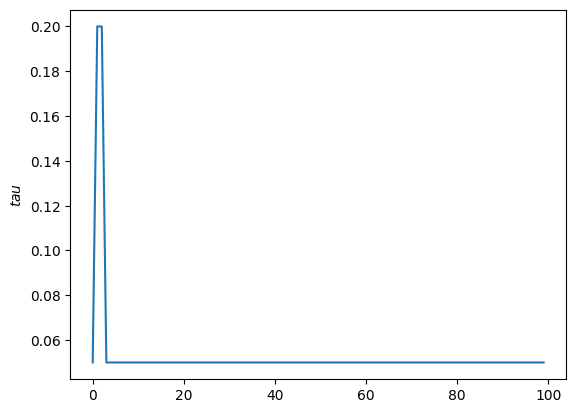

In [171]:
# Set up the basic features of the simulation

# Total simulation time
T = 100
# Initial level of capital
k0 = Qmodel.kss

# Design the shock:

# for this example, I am assuming that productivity increases and then
# goes back to the original level.

tau_high = 0.2
param_sequence_temp = np.array([tau]*1+
                        [tau_high]*2+
                        [tau]*(T-1-2))
# Check the pattern of the shock
plt.figure()
plt.plot(param_sequence_temp)
plt.ylabel('$tau$')

# Dolo receives a DataFrame with the full future paths for ALL exogenous
# variables. So we create one:
Exog = pd.DataFrame({'R':[R]*T,
                     'psi':[psi]*T,
                     'itc_1':[zeta]*T,
                     'tau':param_sequence_temp})

# Examine the first few entries.
Exog.head()
# Note all other variables are left constant.

In [172]:
# Now use the "perfect foresight" dolo solver
response = pf.deterministic_solve(model = QDolo, # Model we are using (in dolo)
                                  shocks = Exog, # Paths for exog. variables 
                                  T=T,           # Total simulation time
                                  s1 = [k0],     # Initial state
                                  verbose=True)

# Response is a DataFrame with the paths of every variable over time.
# It adds information we don't need on the first row. So we delete it
response = response[1:]

# Inspect the first few elements.
response.head()

	> 1 | 0.10189071312408393 | 0
	> 2 | 0.035540033639312574 | 0
	> 3 | 0.0067584374144583625 | 0
	> 4 | 0.0002939664195852343 | 0
	> 5 | 5.058663679058384e-07 | 0
> System was solved after iteration 5. Residual=5.058663679058384e-07


,k,i,y,y_k,beta,j,xi,iota,j_i,j_k,lambda_1,q_1,R,tau,itc_1,psi
1,4.298990,0.415783,1.618121,0.124211,0.98,0.000232,0.407694,-0.003284,-0.032836,0.003230,0.967164,0.967164,1.020408,0.20,0.0,1.0
2,4.284874,0.422176,1.616365,0.124485,0.98,0.000046,0.413778,-0.001473,-0.014729,0.001462,0.985271,0.985271,1.020408,0.20,0.0,1.0
3,4.278563,0.429421,1.615579,0.124608,0.98,0.000003,0.420836,0.000366,0.003658,-0.000366,1.003658,1.003658,1.020408,0.05,0.0,1.0
4,4.280128,0.429458,1.615774,0.124577,0.98,0.000002,0.420871,0.000338,0.003377,-0.000338,1.003377,1.003377,1.020408,0.05,0.0,1.0
5,4.281574,0.429492,1.615954,0.124549,0.98,0.000002,0.420904,0.000312,0.003117,-0.000312,1.003117,1.003117,1.020408,0.05,0.0,1.0


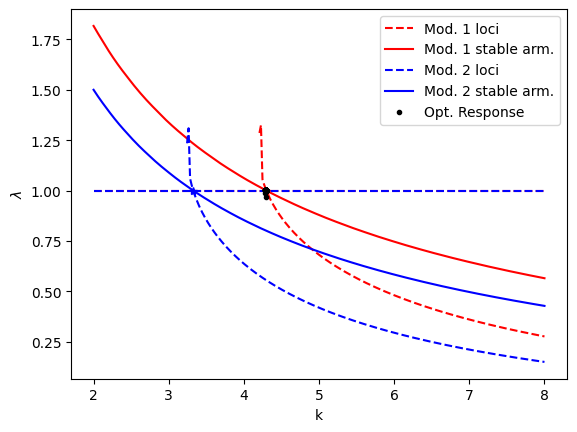

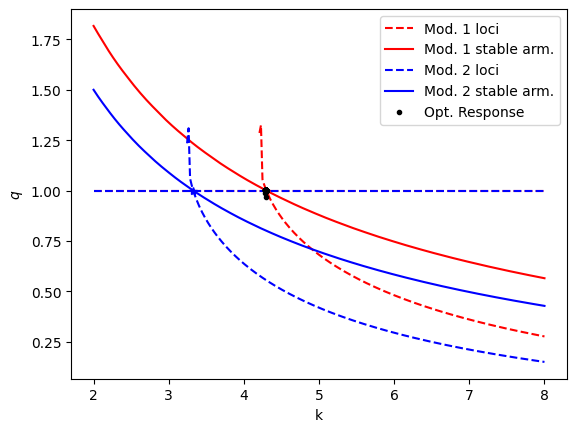

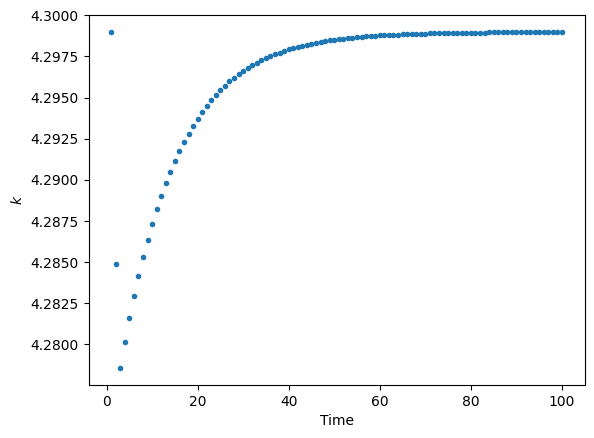

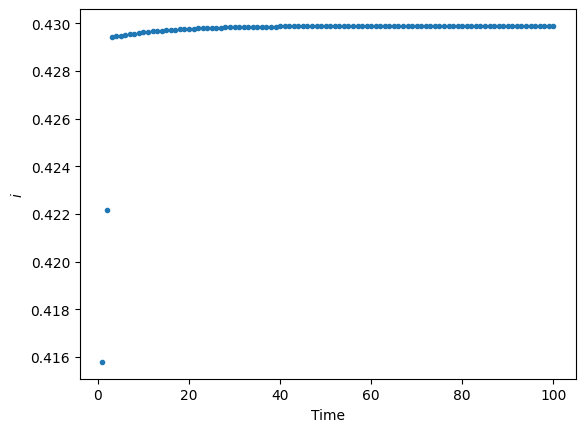

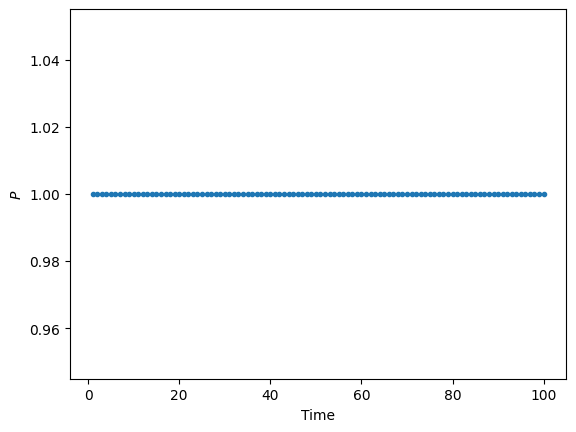

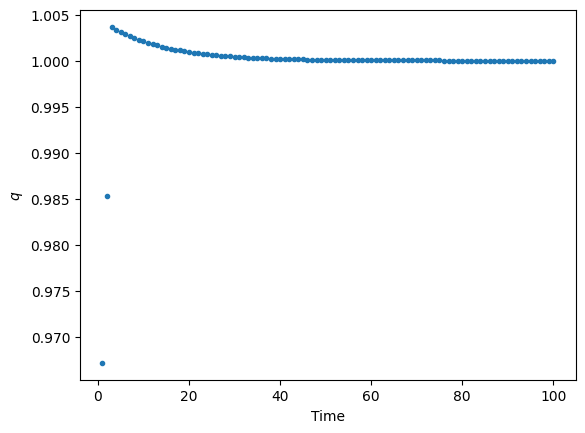

In [173]:
# Draw the two phase diagrams and save them in an object
# to add the plots of dynamics later.

# Copy the initial model, set the higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.tau = tau_high
Q_high_tau.solve()

# Now we draw the phase diagrams of our base model "Qmodel"
# lambda dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.lambda_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$\\lambda$')

# Save the plot as a PNG file
plt.savefig('./fig/Q2_high_lambda'); plt.show()

# q dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.q_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$q$')
plt.savefig('./fig/Q2_high_q'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.k,'.')
plt.ylabel('$k$')
plt.xlabel('Time')
plt.savefig('./fig/Q2_high_k'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.i,'.')
plt.ylabel('$i$')
plt.xlabel('Time')
plt.savefig('./fig/Q2_high_i'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.lambda_1/response.q_1,'.')
plt.ylabel('$P$')
plt.xlabel('Time')
plt.savefig('./fig/Q2_high_P'); plt.show()

plt.figure()
plt.plot(response.q_1,'.')
plt.ylabel('$q$')
plt.xlabel('Time')
plt.savefig('./fig/Q2_high_q2'); plt.show()

## Case2. costs of adjustment(w) are low

In [174]:
# Base parameters
beta = 0.98 #Discount factor
R = 1/beta #return factor
tau = 0.05 # Tax rate
alpha = 0.33 # Share of capital in production
omega = 1 # Adjustment costs
zeta = 0 # Investment tax credit
delta = 0.1 # Depreciation rate
psi = 1 # Technological factor

## Qmod python class
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
Qmodel.solve()

## Dolo
QDolo = yaml_import("../Dolo/Q-model.yaml")
QDolo.set_calibration(alpha = alpha, delta = delta, omega = omega)


,R,psi,itc_1,tau
0,1.020408,1,0,0.05
1,1.020408,1,0,0.20
2,1.020408,1,0,0.20
3,1.020408,1,0,0.05
4,1.020408,1,0,0.05


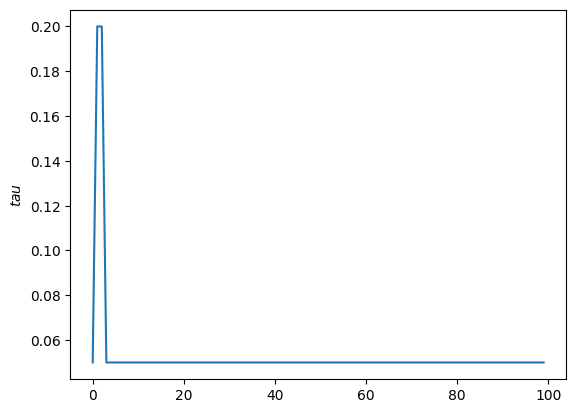

In [175]:
# Set up the basic features of the simulation

# Total simulation time
T = 100
# Initial level of capital
k0 = Qmodel.kss

# Design the shock:

# for this example, I am assuming that productivity increases and then
# goes back to the original level.

tau_high = 0.2
param_sequence_temp = np.array([tau]*1+
                        [tau_high]*2+
                        [tau]*(T-1-2))
# Check the pattern of the shock
plt.figure()
plt.plot(param_sequence_temp)
plt.ylabel('$tau$')

# Dolo receives a DataFrame with the full future paths for ALL exogenous
# variables. So we create one:
Exog = pd.DataFrame({'R':[R]*T,
                     'psi':[psi]*T,
                     'itc_1':[zeta]*T,
                     'tau':param_sequence_temp})

# Examine the first few entries.
Exog.head()
# Note all other variables are left constant.

In [176]:
# Now use the "perfect foresight" dolo solver
response = pf.deterministic_solve(model = QDolo, # Model we are using (in dolo)
                                  shocks = Exog, # Paths for exog. variables 
                                  T=T,           # Total simulation time
                                  s1 = [k0],     # Initial state
                                  verbose=True)

# Response is a DataFrame with the paths of every variable over time.
# It adds information we don't need on the first row. So we delete it
response = response[1:]

# Inspect the first few elements.
response.head()

	> 1 | 0.08584546283991046 | 0
	> 2 | 0.02893972960882052 | 0
	> 3 | 0.005488334012042184 | 0
	> 4 | 0.00026282053170878505 | 0
	> 5 | 6.067818323352014e-07 | 0
> System was solved after iteration 5. Residual=6.067818323352014e-07


,k,i,y,y_k,beta,j,xi,iota,j_i,j_k,lambda_1,q_1,R,tau,itc_1,psi
1,4.298990,0.322011,1.618121,0.124211,0.98,0.001354,0.316898,-0.025096,-0.025096,0.002195,0.974904,0.974904,1.020408,0.20,0.0,1.0
2,4.191103,0.384018,1.604606,0.126344,0.98,0.000147,0.376482,-0.008373,-0.008373,0.000802,0.991627,0.991627,1.020408,0.20,0.0,1.0
3,4.156011,0.449310,1.600160,0.127058,0.98,0.000137,0.440458,0.008111,0.008111,-0.000844,1.008111,1.008111,1.020408,0.05,0.0,1.0
4,4.189720,0.444791,1.604431,0.126372,0.98,0.000080,0.435973,0.006162,0.006162,-0.000635,1.006162,1.006162,1.020408,0.05,0.0,1.0
5,4.215539,0.441305,1.607687,0.125853,0.98,0.000046,0.432525,0.004685,0.004685,-0.000480,1.004685,1.004685,1.020408,0.05,0.0,1.0


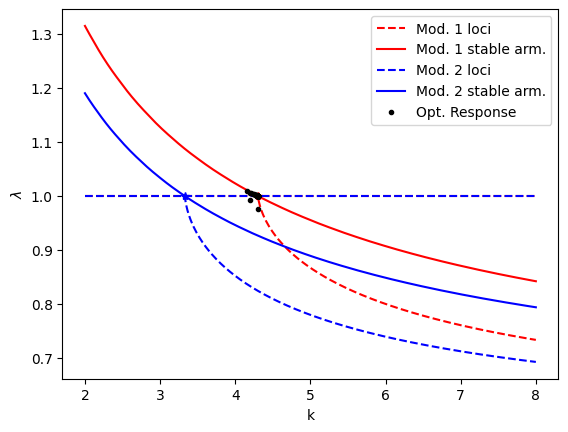

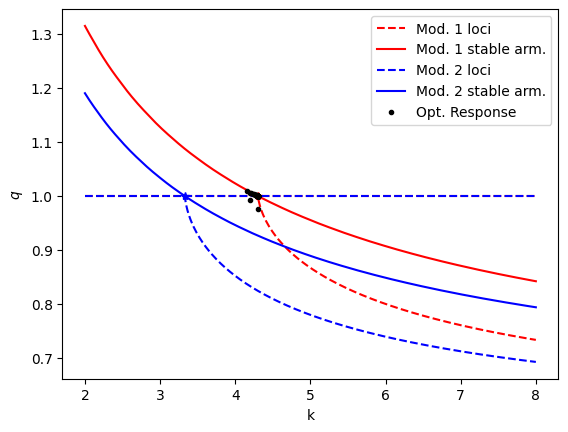

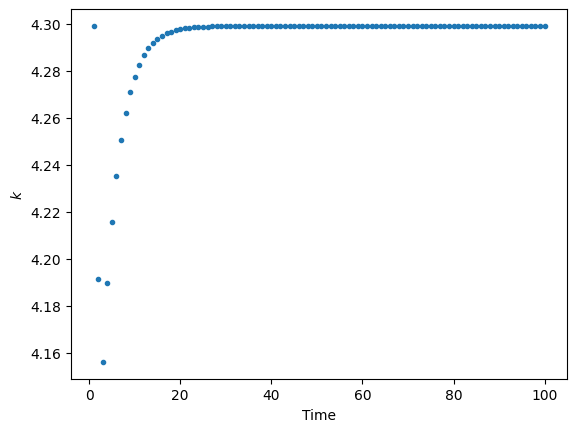

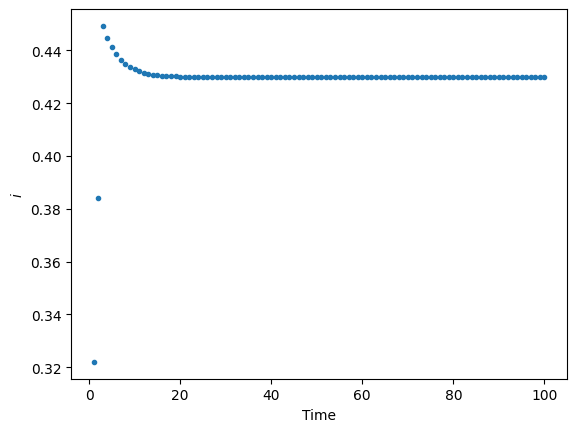

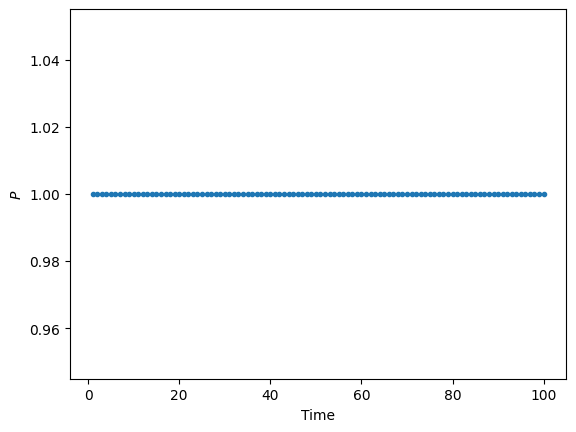

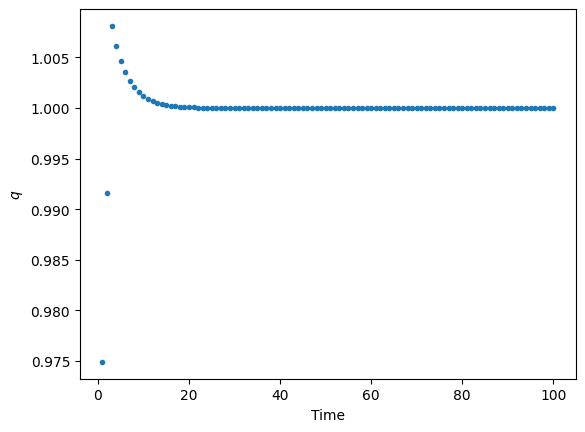

In [177]:
# Draw the two phase diagrams and save them in an object
# to add the plots of dynamics later.

# Copy the initial model, set the higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.tau = tau_high
Q_high_tau.solve()

# Now we draw the phase diagrams of our base model "Qmodel"
# lambda dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.lambda_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$\\lambda$')

# Save the plot as a PNG file
plt.savefig('./fig/Q2_low_lambda'); plt.show()

# q dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.q_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$q$')
plt.savefig('./fig/Q2_low_q'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.k,'.')
plt.ylabel('$k$')
plt.xlabel('Time')
plt.savefig('./fig/Q2_low_k'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.i,'.')
plt.ylabel('$i$')
plt.xlabel('Time')
plt.savefig('./fig/Q2_low_i'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.lambda_1/response.q_1,'.')
plt.ylabel('$P$')
plt.xlabel('Time')
plt.savefig('./fig/Q2_low_P'); plt.show()

plt.figure()
plt.plot(response.q_1,'.')
plt.ylabel('$q$')
plt.xlabel('Time')
plt.savefig('./fig/Q2_low_q2'); plt.show()

# Q3. unexpected permanent decrease in corporate tax rate¶

## Case1. costs of adjustment(w) are high

Suppose w is 10

In [178]:
# Base parameters
beta = 0.98 #Discount factor
R = 1/beta #return factor
tau = 0.2 # Tax rate
alpha = 0.33 # Share of capital in production
omega = 10 # Adjustment costs
zeta = 0 # Investment tax credit
delta = 0.1 # Depreciation rate
psi = 1 # Technological factor

## Qmod python class
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
Qmodel.solve()

## Dolo
QDolo = yaml_import("../Dolo/Q-model.yaml")
QDolo.set_calibration(alpha = alpha, delta = delta, omega = omega)

,R,psi,itc_1,tau
0,1.020408,1,0,0.20
1,1.020408,1,0,0.20
2,1.020408,1,0,0.20
3,1.020408,1,0,0.05
4,1.020408,1,0,0.05


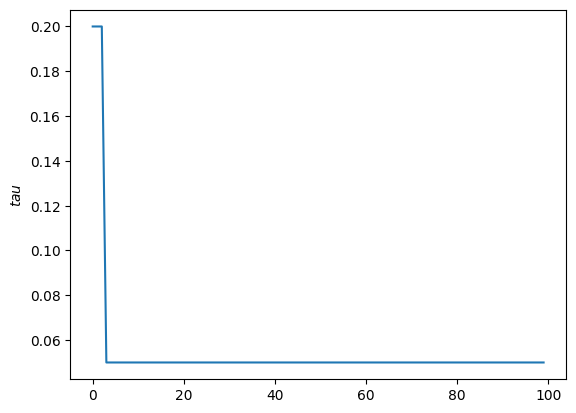

In [179]:
# Set up the basic features of the simulation
T = 100 # Total simulation time
k0 = Qmodel.kss # Initial level of capital

# Design the shock:
# for this example, I am assuming that productivity increases and then
# goes back to the original level.

tau_low = 0.05
param_sequence_perm = np.array([tau]*3+
                        [tau_low]*97)
# Check the pattern of the shock
plt.figure()
plt.plot(param_sequence_perm)
plt.ylabel('$tau$')

# Dolo receives a DataFrame with the full future paths for ALL exogenous
# variables. So we create one:
Exog = pd.DataFrame({'R':[R]*T,
                     'psi':[psi]*T,
                     'itc_1':[zeta]*T,
                     'tau':param_sequence_perm})

# Examine the first few entries.
Exog.head()
# Note all other variables are left constant.

In [180]:
# Now use the "perfect foresight" dolo solver
response = pf.deterministic_solve(model = QDolo, # Model we are using (in dolo)
                                  shocks = Exog, # Paths for exog. variables 
                                  T=T,           # Total simulation time
                                  s1 = [k0],     # Initial state
                                  verbose=True)

# Response is a DataFrame with the paths of every variable over time.
# It adds information we don't need on the first row. So we delete it
response = response[1:]

# Inspect the first few elements.
response.head()

	> 1 | 0.09630610262371331 | 0
	> 2 | 0.033293901081064003 | 0
	> 3 | 0.006353916549181049 | 0
	> 4 | 0.00028655560814494496 | 0
	> 5 | 5.422271707189452e-07 | 0
> System was solved after iteration 5. Residual=5.422271707189452e-07


,k,i,y,y_k,beta,j,xi,iota,j_i,j_k,lambda_1,q_1,R,tau,itc_1,psi
1,3.326389,0.389992,1.486795,0.147500,0.98,0.004944,0.387038,0.017242,0.172419,-0.018728,1.172419,1.172419,1.020408,0.20,0.0,1.0
2,3.383742,0.397848,1.495206,0.145820,0.98,0.005227,0.395014,0.017576,0.175764,-0.019121,1.175764,1.175764,1.020408,0.20,0.0,1.0
3,3.443216,0.406463,1.503828,0.144128,0.98,0.005608,0.403829,0.018048,0.180476,-0.019676,1.180476,1.180476,1.020408,0.05,0.0,1.0
4,3.505358,0.408427,1.512731,0.142411,0.98,0.004780,0.404944,0.016515,0.165152,-0.017879,1.165152,1.165152,1.020408,0.05,0.0,1.0
5,3.563249,0.410216,1.520930,0.140857,0.98,0.004075,0.406006,0.015124,0.151242,-0.016268,1.151242,1.151242,1.020408,0.05,0.0,1.0


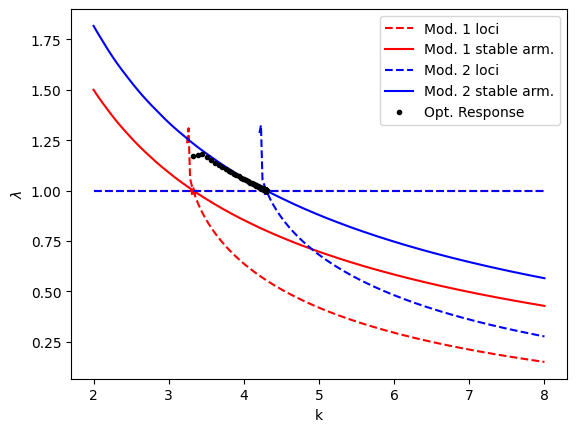

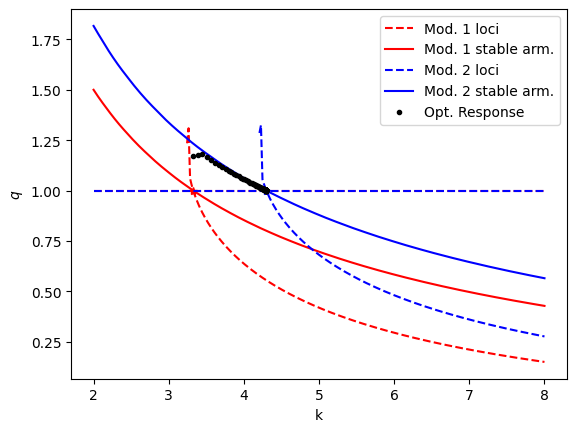

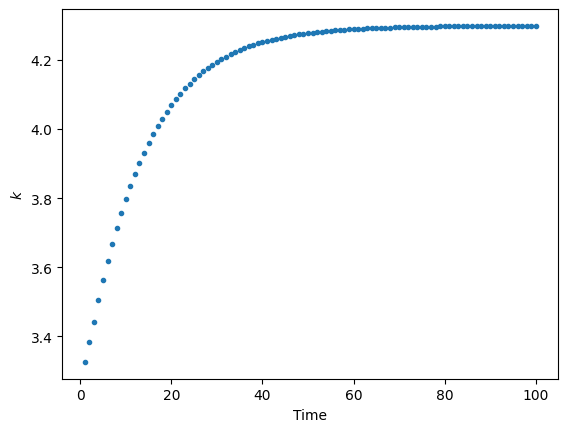

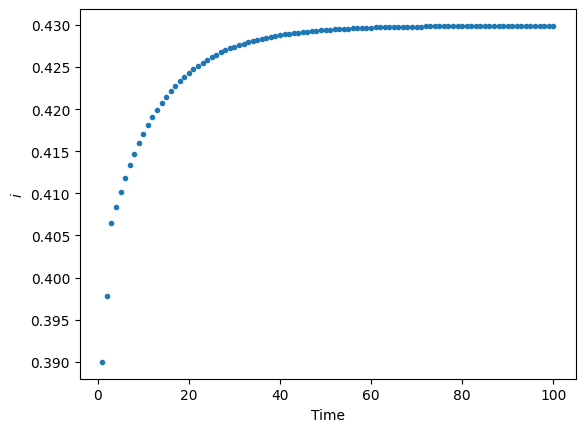

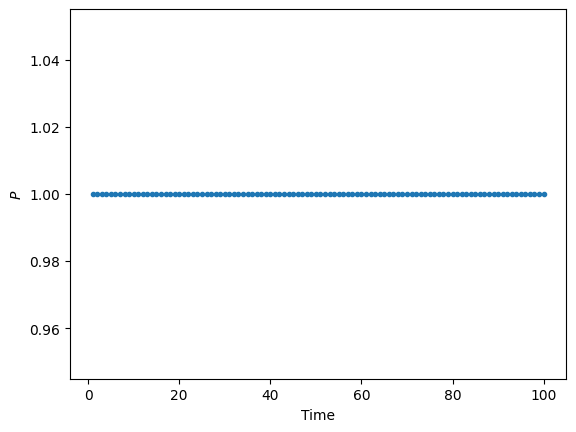

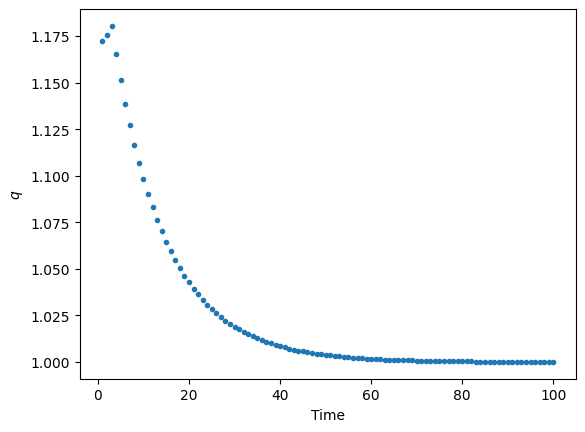

In [181]:
# Draw the two phase diagrams and save them in an object
# to add the plots of dynamics later.

# Copy the initial model, set the higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.tau = tau_low
Q_high_tau.solve()

# Now we draw the phase diagrams of our base model "Qmodel"
# lambda dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.lambda_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$\\lambda$')
plt.savefig('./fig/Q3_high_lambda'); plt.show()

# q dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.q_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$q$')
plt.savefig('./fig/Q3_high_q'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.k,'.')
plt.ylabel('$k$')
plt.xlabel('Time')
plt.savefig('./fig/Q3_high_k'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.i,'.')
plt.ylabel('$i$')
plt.xlabel('Time')
plt.savefig('./fig/Q3_high_i'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.lambda_1/response.q_1,'.')
plt.ylabel('$P$')
plt.xlabel('Time')
plt.savefig('./fig/Q3_high_P'); plt.show()

plt.figure()
plt.plot(response.q_1,'.')
plt.ylabel('$q$')
plt.xlabel('Time')
plt.savefig('./fig/Q3_high_q2'); plt.show()

## Case2. costs of adjustment(w) are low

Suppose w is 1

In [182]:
# Base parameters
beta = 0.98 #Discount factor
R = 1/beta #return factor
tau = 0.2 # Tax rate
alpha = 0.33 # Share of capital in production
omega = 1 # Adjustment costs
zeta = 0 # Investment tax credit
delta = 0.1 # Depreciation rate
psi = 1 # Technological factor

## Qmod python class
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
Qmodel.solve()

## Dolo
QDolo = yaml_import("../Dolo/Q-model.yaml")
QDolo.set_calibration(alpha = alpha, delta = delta, omega = omega)

,R,psi,itc_1,tau
0,1.020408,1,0,0.20
1,1.020408,1,0,0.20
2,1.020408,1,0,0.20
3,1.020408,1,0,0.05
4,1.020408,1,0,0.05


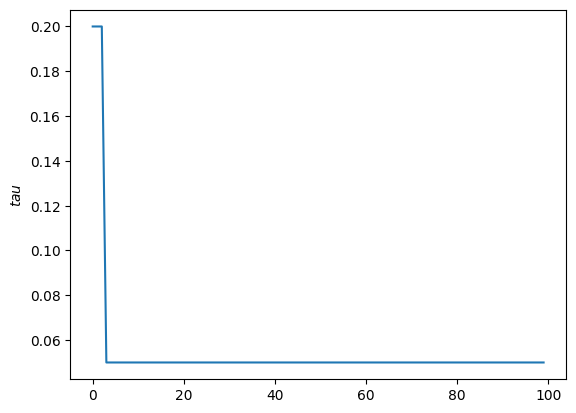

In [183]:
# Set up the basic features of the simulation
T = 100 # Total simulation time
k0 = Qmodel.kss # Initial level of capital

# Design the shock:
# for this example, I am assuming that productivity increases and then
# goes back to the original level.

tau_low = 0.05
param_sequence_perm = np.array([tau]*3+
                        [tau_low]*97)
# Check the pattern of the shock
plt.figure()
plt.plot(param_sequence_perm)
plt.ylabel('$tau$')

# Dolo receives a DataFrame with the full future paths for ALL exogenous
# variables. So we create one:
Exog = pd.DataFrame({'R':[R]*T,
                     'psi':[psi]*T,
                     'itc_1':[zeta]*T,
                     'tau':param_sequence_perm})

# Examine the first few entries.
Exog.head()
# Note all other variables are left constant.

In [184]:
# Now use the "perfect foresight" dolo solver
response = pf.deterministic_solve(model = QDolo, # Model we are using (in dolo)
                                  shocks = Exog, # Paths for exog. variables 
                                  T=T,           # Total simulation time
                                  s1 = [k0],     # Initial state
                                  verbose=True)

# Response is a DataFrame with the paths of every variable over time.
# It adds information we don't need on the first row. So we delete it
response = response[1:]

# Inspect the first few elements.
response.head()

	> 1 | 0.08520376386846251 | 0
	> 2 | 0.02867493707744606 | 0
	> 3 | 0.005454479667516887 | 0
	> 4 | 0.0002670149335519678 | 0
	> 5 | 6.588708613142202e-07 | 0
> System was solved after iteration 5. Residual=6.588708613142202e-07


,k,i,y,y_k,beta,j,xi,iota,j_i,j_k,lambda_1,q_1,R,tau,itc_1,psi
1,3.326389,0.454429,1.486795,0.147500,0.98,0.002230,0.447526,0.036613,0.036613,-0.004332,1.036613,1.036613,1.020408,0.20,0.0,1.0
2,3.448179,0.480844,1.504543,0.143989,0.98,0.002683,0.473857,0.039449,0.039449,-0.004723,1.039449,1.039449,1.020408,0.20,0.0,1.0
3,3.584206,0.520106,1.523876,0.140304,0.98,0.003647,0.513278,0.045111,0.045111,-0.005529,1.045111,1.045111,1.020408,0.05,0.0,1.0
4,3.745891,0.501276,1.546227,0.136217,0.98,0.002142,0.493350,0.033820,0.033820,-0.003954,1.033820,1.033820,1.020408,0.05,0.0,1.0
5,3.872578,0.485843,1.563292,0.133215,0.98,0.001255,0.477356,0.025457,0.025457,-0.002870,1.025457,1.025457,1.020408,0.05,0.0,1.0


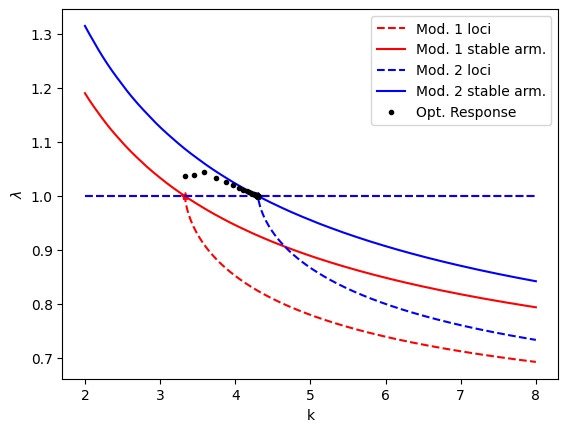

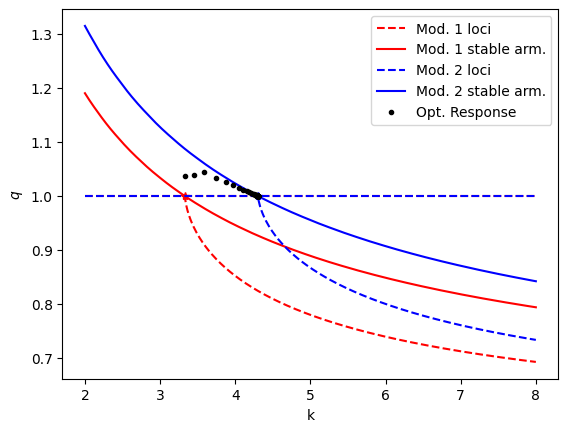

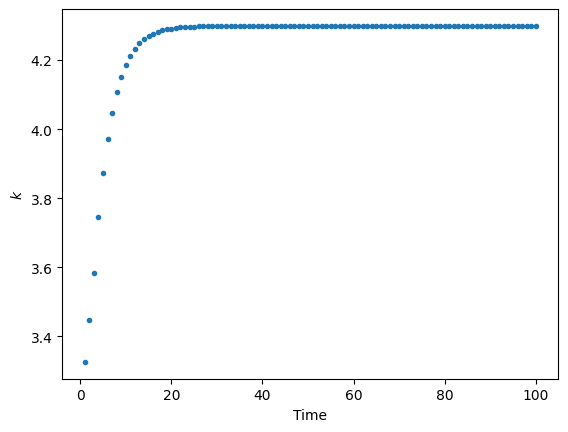

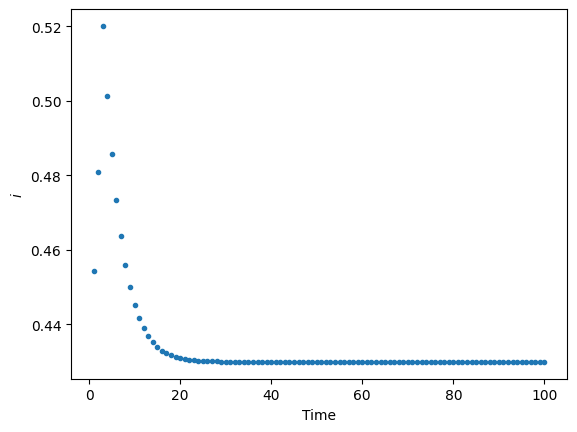

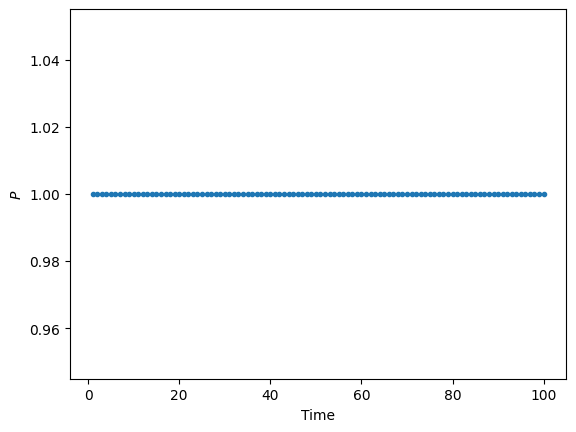

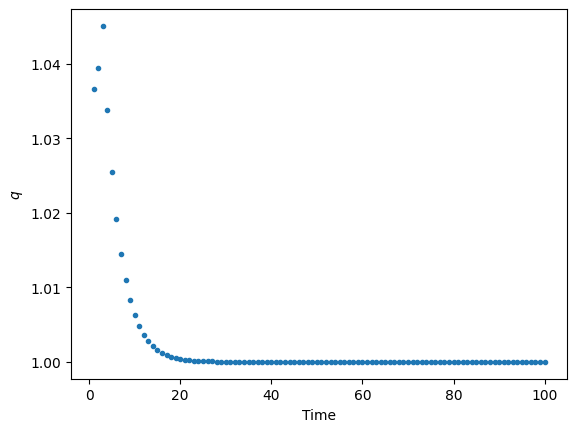

In [185]:
# Draw the two phase diagrams and save them in an object
# to add the plots of dynamics later.

# Copy the initial model, set the higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.tau = tau_low
Q_high_tau.solve()

# Now we draw the phase diagrams of our base model "Qmodel"
# lambda dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.lambda_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$\\lambda$')
plt.savefig('./fig/Q3_low_lambda'); plt.show()

# q dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.q_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$q$')
plt.savefig('./fig/Q3_low_q'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.k,'.')
plt.ylabel('$k$')
plt.xlabel('Time')
plt.savefig('./fig/Q3_low_k'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.i,'.')
plt.ylabel('$i$')
plt.xlabel('Time')
plt.savefig('./fig/Q3_low_i'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.lambda_1/response.q_1,'.')
plt.ylabel('$P$')
plt.xlabel('Time')
plt.savefig('./fig/Q3_low_P'); plt.show()

plt.figure()
plt.plot(response.q_1,'.')
plt.ylabel('$q$')
plt.xlabel('Time')
plt.savefig('./fig/Q3_low_q2'); plt.show()

# Q4. Unexpected permanent ITC change

In [186]:
# Base parameters
beta = 0.98 #Discount factor
R = 1/beta #return factor
tau = 0.2 # Tax rate
alpha = 0.33 # Share of capital in production
omega = 1 # Adjustment costs
zeta = 0 # Investment tax credit
delta = 0.1 # Depreciation rate
psi = 1 # Technological factor

## Qmod python class
Qmodel = Qmod(beta, tau, alpha, omega, zeta, delta, psi)
Qmodel.solve()

## Dolo
QDolo = yaml_import("../Dolo/Q-model.yaml")
QDolo.set_calibration(alpha = alpha, delta = delta, omega = omega)

,R,psi,itc_1,tau
0,1.020408,1,0.0,0.2
1,1.020408,1,0.0,0.2
2,1.020408,1,0.0,0.2
3,1.020408,1,0.3,0.2
4,1.020408,1,0.3,0.2


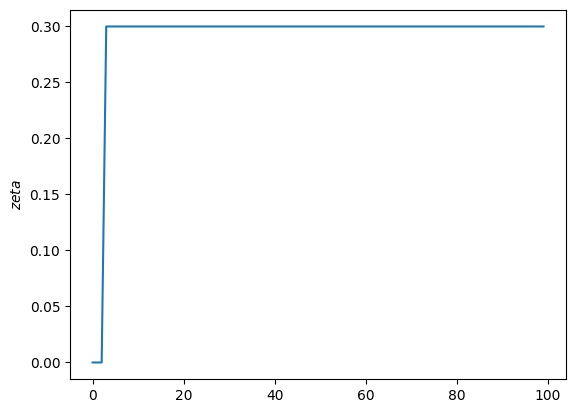

In [187]:
# Set up the basic features of the simulation
T = 100 # Total simulation time
k0 = Qmodel.kss # Initial level of capital

# Design the shock:
# for this example, I am assuming that productivity increases and then
# goes back to the original level.

zeta_high = 0.3
param_sequence_perm = np.array([zeta]*3+
                        [zeta_high]*97)
# Check the pattern of the shock
plt.figure()
plt.plot(param_sequence_perm)
plt.ylabel('$zeta$')

# Dolo receives a DataFrame with the full future paths for ALL exogenous
# variables. So we create one:
Exog = pd.DataFrame({'R':[R]*T,
                     'psi':[psi]*T,
                     'itc_1':param_sequence_perm,
                     'tau':[tau]*T})

# Examine the first few entries.
Exog.head()
# Note all other variables are left constant.

In [188]:
# Now use the "perfect foresight" dolo solver
response = pf.deterministic_solve(model = QDolo, # Model we are using (in dolo)
                                  shocks = Exog, # Paths for exog. variables 
                                  T=T,           # Total simulation time
                                  s1 = [k0],     # Initial state
                                  verbose=True)

# Response is a DataFrame with the paths of every variable over time.
# It adds information we don't need on the first row. So we delete it
response = response[1:]

# Inspect the first few elements.
response.head()

	> 1 | 0.09438394825478469 | 0
	> 2 | 0.031316973899381706 | 0
	> 3 | 0.007807743494404162 | 0
	> 4 | 0.0007252797491973384 | 0
	> 5 | 7.072975992339359e-06 | 0
	> 6 | 6.319468282001139e-10 | 0
> System was solved after iteration 6. Residual=6.319468282001139e-10


,k,i,y,y_k,beta,j,xi,iota,j_i,j_k,lambda_1,q_1,R,tau,itc_1,psi
1,3.326389,0.058001,1.486795,0.147500,0.98,0.011338,0.067952,-0.082563,-0.082563,0.004848,0.917437,0.917437,1.020408,0.2,0.0,1.0
2,3.051751,0.012164,1.445111,0.156267,0.98,0.014067,0.025706,-0.096014,-0.096014,0.004992,0.903986,0.903986,1.020408,0.2,0.0,1.0
3,2.758740,0.834001,1.397766,0.167201,0.98,0.056458,0.610855,0.202312,0.202312,-0.040696,0.841619,1.202312,1.020408,0.2,0.3,1.0
4,3.316867,0.809719,1.485389,0.147784,0.98,0.034447,0.579098,0.144122,0.144122,-0.024798,0.800885,1.144122,1.020408,0.2,0.3,1.0
5,3.794899,0.776175,1.552873,0.135036,0.98,0.020733,0.546679,0.104531,0.104531,-0.015916,0.773172,1.104531,1.020408,0.2,0.3,1.0


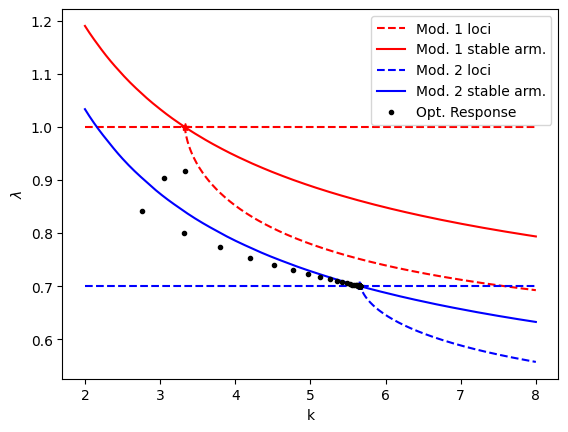

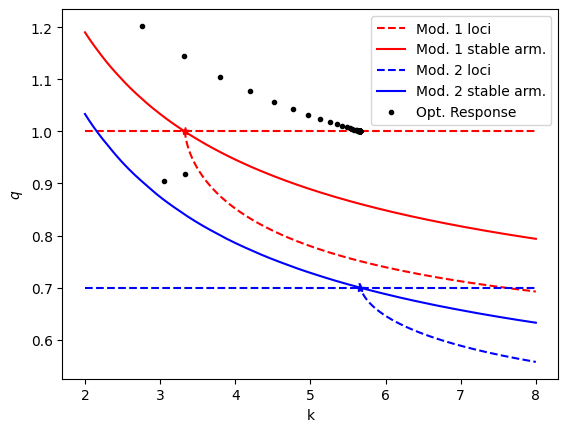

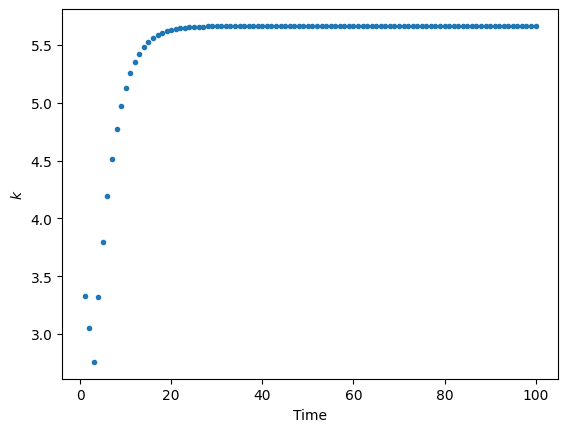

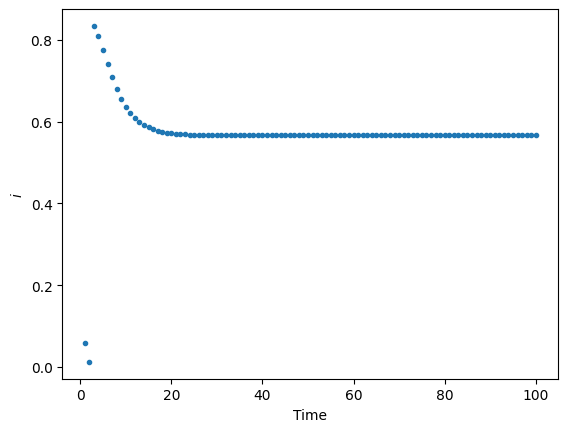

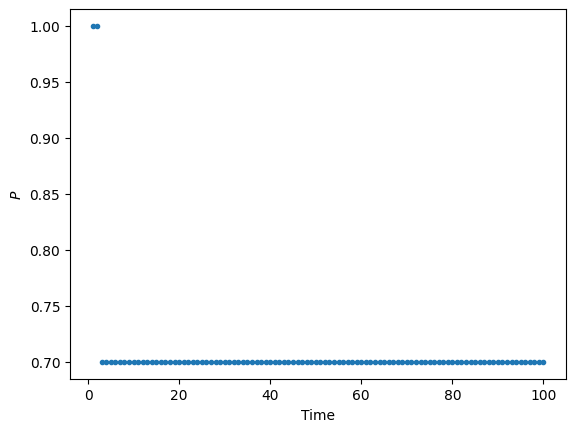

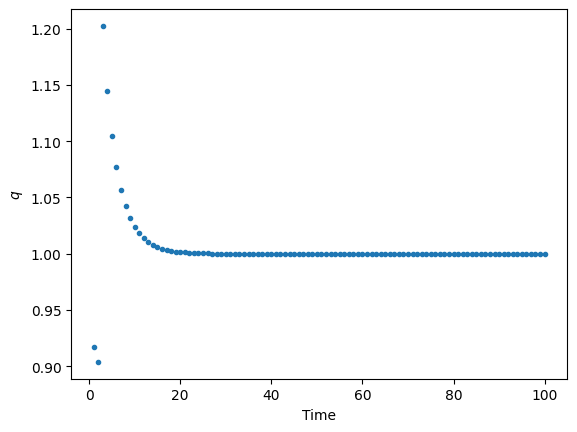

In [189]:
# Draw the two phase diagrams and save them in an object
# to add the plots of dynamics later.

# Copy the initial model, set the higher psi and re-solve
Q_high_tau = deepcopy(Qmodel)
Q_high_tau.zeta = zeta_high
Q_high_tau.solve()

# Now we draw the phase diagrams of our base model "Qmodel"
# lambda dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.lambda_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$\\lambda$')
plt.savefig('./fig/Q4_low_lambda'); plt.show()

# q dynamics
ax = phase_diagrams(mod1 = Qmodel, mod2 = Q_high_tau, k_min = 2, k_max = 8)
# Now we can add the behavior of lambda and k to the diagram.
ax.plot(response.k, response.q_1, '.k',label = 'Opt. Response')
plt.legend()
plt.xlabel('k')
plt.ylabel('$q$')
plt.savefig('./fig/Q4_low_q'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.k,'.')
plt.ylabel('$k$')
plt.xlabel('Time')
plt.savefig('./fig/Q4_low_k'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.i,'.')
plt.ylabel('$i$')
plt.xlabel('Time')
plt.savefig('./fig/Q4_low_i'); plt.show()

# New figure for capital dynamics
plt.figure()
plt.plot(response.lambda_1/response.q_1,'.')
plt.ylabel('$P$')
plt.xlabel('Time')
plt.savefig('./fig/Q4_low_P'); plt.show()

plt.figure()
plt.plot(response.q_1,'.')
plt.ylabel('$q$')
plt.xlabel('Time')
plt.savefig('./fig/Q4_low_q2'); plt.show()